In [313]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


In [314]:
NUM_STATES = 1000
START_STATE = (NUM_STATES + 1) // 2  # 500 for 1000 states
LEFT_TERMINAL_STATE = 0
RIGHT_TERMINAL_STATE = NUM_STATES + 1  # 1001

GAMMA = 1.0
NUM_RUNS = 100
NUM_EPISODES = 10  # For averaging error on right plot
SEED = 42  # For reproducibility, if desired

# Smoother increment for ALPHA (step-size parameter)
ALPHA_VALUES = np.arange(0, 1.05, 0.05)  # 0,0.05,0.1,...,1.0
N_VALUES = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

# For the left figure: 10 groups of 100 states each
NUM_GROUPS_LEFT_PLOT = 10

# For the right figure: 20 groups of 50 states each
NUM_GROUPS_RIGHT_PLOT = 20


In [315]:
class RandomWalkEnvironment:
    """
    1000-state random walk environment used in Example 9.2 of the textbook.
    
    States:
        Integer states from 1 to NUM_STATES (e.g., 1 to 1000).
        Two terminal states: LEFT_TERMINAL_STATE (0) and RIGHT_TERMINAL_STATE (1001).
    
    Dynamics:
        - Start in the middle state (e.g., 500 for 1000 states).
        - On each step:
          * Randomly select a step size from {1,...,100}.
          * Randomly choose a direction (left/right) with probability 0.5 each.
          * next_state = current_state ± step_size
        - If next_state <= 0, then next_state=0, reward=-1, episode ends.
        - If next_state >= 1001, then next_state=1001, reward=+1, episode ends.
        - Otherwise, reward=0, continue episode.
    """
    def __init__(self):
        self.current_state = None

    def reset(self):
        """Reset environment to the start state and return it."""
        self.current_state = START_STATE
        return self.current_state

    def step(self):
        """
        Take one step in the environment.
        
        Returns:
            next_state (int): next state after transition
            reward (float): reward obtained
            done (bool): whether the episode ended
        """
        step_size = np.random.randint(1, 101)
        direction = np.random.choice([-1, 1])
        next_state = self.current_state + direction * step_size

        if next_state <= LEFT_TERMINAL_STATE:
            next_state = LEFT_TERMINAL_STATE
            reward = -1.0
            done = True
        elif next_state >= RIGHT_TERMINAL_STATE:
            next_state = RIGHT_TERMINAL_STATE
            reward = 1.0
            done = True
        else:
            reward = 0.0
            done = False

        self.current_state = next_state
        return next_state, reward, done
    

In [316]:
def get_state_feature(state, num_groups, num_states=NUM_STATES):
    """
    Construct a state feature vector based on state aggregation.
    
    Args:
        state (int): current state
        num_groups (int): number of state aggregation groups
        num_states (int): total number of non-terminal states

    Returns:
        feature (np.ndarray): one-hot feature vector with length = num_groups
    """
    # Terminal states have zero feature vector
    if state == LEFT_TERMINAL_STATE or state == RIGHT_TERMINAL_STATE:
        return np.zeros(num_groups)
    group_size = num_states // num_groups
    group_index = (state - 1) // group_size
    # Ensure we don't exceed group bounds due to integer division quirks
    if group_index >= num_groups:
        group_index = num_groups - 1
    feature = np.zeros(num_groups)
    feature[group_index] = 1.0
    return feature


In [317]:
class Agent:
    """
    Agent implementing linear (semi-gradient) TD methods with state aggregation.
    
    The value function approximation is linear in the weights:
        v_hat(s, w) = w^T x(s)
    where x(s) is the feature vector for state s.
    
    The update rules:
    - Semi-gradient TD(0):
        w <- w + alpha [r + gamma v_hat(s',w) - v_hat(s,w)] x(s)
    - n-step semi-gradient TD:
        w <- w + alpha [G_{t:t+n} - v_hat(S_t,w)] x(S_t)
    """
    def __init__(self, num_groups, alpha):
        """
        Initialize the agent.
        
        Args:
            num_groups (int): number of aggregation groups (feature dimensions)
            alpha (float): step-size parameter
        """
        self.num_groups = num_groups
        self.alpha = alpha
        self.weights = np.zeros(num_groups)

    def value(self, state):
        """
        Compute the estimated value for a given state.
        
        Args:
            state (int): current state
        
        Returns:
            float: value estimate for the state
        """
        x = get_state_feature(state, self.num_groups)
        return np.dot(self.weights, x)

    def semi_gradient_td0_update(self, state, reward, next_state):
        """
        Perform one step of semi-gradient TD(0) update.
        
        Update rule:
            w <- w + alpha [r + gamma v_hat(s',w) - v_hat(s,w)] x(s)
        
        Args:
            state (int): current state
            reward (float): observed reward
            next_state (int): next state after transition
        """
        x_t = get_state_feature(state, self.num_groups)
        v_t = np.dot(self.weights, x_t)
        if next_state == LEFT_TERMINAL_STATE or next_state == RIGHT_TERMINAL_STATE:
            v_t1 = 0.0
        else:
            x_t1 = get_state_feature(next_state, self.num_groups)
            v_t1 = np.dot(self.weights, x_t1)
        delta = reward + GAMMA * v_t1 - v_t
        self.weights += self.alpha * delta * x_t

    def n_step_semi_gradient_td(self, n, env):
        """
        Perform one episode of n-step semi-gradient TD.
        
        Args:
            n (int): number of steps for n-step return
            env (RandomWalkEnvironment): environment instance
        
        The update rule for each state S_t visited in the episode:
            w <- w + alpha [G_{t:t+n} - v_hat(S_t,w)] x(S_t)
        where G_{t:t+n} is the n-step return.
        """
        state = env.reset()
        T = float('inf')
        t = 0
        states = [state]
        rewards = [0]

        while True:
            if t < T:
                next_state, reward, done = env.step()
                states.append(next_state)
                rewards.append(reward)
                if done:
                    T = t + 1
            tau = t - n + 1
            if tau >= 0:
                # Compute n-step return
                G = 0.0
                for i in range(tau+1, min(tau+n+1, T+1)):
                    G += (GAMMA**(i - tau - 1)) * rewards[i]
                if tau + n < T:
                    G += (GAMMA**n) * self.value(states[tau+n])
                x_tau = get_state_feature(states[tau], self.num_groups)
                v_tau = np.dot(self.weights, x_tau)
                delta = G - v_tau
                self.weights += self.alpha * delta * x_tau
            if tau == T - 1:
                break
            t += 1

    def reset(self):
        """Reset the agent's weights to zero."""
        self.weights = np.zeros(self.num_groups)


In [318]:
def true_value_function():
    """
    Compute the true value function for the 1000-state random walk environment (Example 9.2).
    Instead of assuming a linear mapping, we solve the Bellman equations directly:
    
    For s = 1,...,1000:
        V(s) = (1/(2*100)) * [ sum_{k=1}^{100}((s-k<=0)?(-1):V(s-k)) + sum_{k=1}^{100}((s+k>=1001)?(1):V(s+k)) ]

    This forms a system of linear equations A v = b, which we solve for v.
    """
    n = NUM_STATES  # 1000
    A = np.zeros((n, n))
    b = np.zeros(n)
    
    # Each row of A, b corresponds to one state's equation
    for s in range(1, n+1):  
        # s ranges 1 to 1000 (index in code: s-1)
        A[s-1, s-1] = 1.0  # V(s) on the left side

        # Probability factor from the equation
        factor = 1.0 / (2.0 * 100.0)

        # Transitions going left
        for k in range(1, 101):
            if s - k <= 0:
                # Terminal with reward -1, no future V-value
                b[s-1] += factor * (-1.0)
            else:
                # Subtract factor * V(s-k) from left side
                A[s-1, (s-k)-1] -= factor

        # Transitions going right
        for k in range(1, 101):
            if s + k >= 1001:
                # Terminal with reward +1
                b[s-1] += factor * (1.0)
            else:
                # Subtract factor * V(s+k) from left side
                A[s-1, (s+k)-1] -= factor

    # Solve the linear system
    v = np.linalg.solve(A, b)
    return v

In [319]:
def run_td0_until_convergence(num_groups, alpha):
    """
    Run semi-gradient TD(0) until near-convergence and return the estimated values.
    
    Args:
        num_groups (int): number of feature groups for state aggregation
        alpha (float): step-size parameter
        
    Returns:
        values (np.ndarray): approximate value function for states 1 to NUM_STATES
    """
    env = RandomWalkEnvironment()
    agent = Agent(num_groups, alpha)
    # Run many episodes for near-asymptotic convergence
    for _ in range(1000):
        s = env.reset()
        done = False
        while not done:
            ns, r, done = env.step()
            agent.semi_gradient_td0_update(s, r, ns)
            s = ns
    values = np.zeros(NUM_STATES)
    for s in range(1, NUM_STATES + 1):
        values[s-1] = agent.value(s)
    return values


In [320]:
def plot_first_figure():
    """
    Plot the first figure (left panel of Figure 9.2).
    Shows the true values vs. the semi-gradient TD(0) learned values.
    """
    true_values = true_value_function()
    approximate_values = run_td0_until_convergence(NUM_GROUPS_LEFT_PLOT, alpha=0.1)
    states = np.arange(1, NUM_STATES + 1)

    plt.figure(figsize=(5,5))
    plt.plot(states, true_values, 'r', label='True value $v_\pi$')
    plt.plot(states, approximate_values, 'b', label='Approx. TD value $\hat{v}$')
    plt.xlim(1, 1000)
    plt.ylim(-1, 1)
    plt.xticks([1, 1000], [1, 1000])
    plt.yticks([-1,0,1], [-1,0,1])
    plt.xlabel('State')
    plt.title('')
    plt.legend()
    plt.tight_layout()


In [321]:
def run_experiment(n, alpha, num_groups):
    """
    Run one experiment of n-step semi-gradient TD and return average RMS error.
    
    Args:
        n (int): number of steps (n-step TD)
        alpha (float): step-size
        num_groups (int): number of feature groups
    
    Returns:
        float: average RMS error over the first NUM_EPISODES episodes.
    """
    env = RandomWalkEnvironment()
    agent = Agent(num_groups, alpha)
    true_values = true_value_function()
    errors = []
    for _ in range(NUM_EPISODES):
        # Run one episode of n-step TD
        agent.n_step_semi_gradient_td(n, env)
        estimated_values = np.zeros(NUM_STATES)
        for s in range(1, NUM_STATES + 1):
            estimated_values[s-1] = agent.value(s)
        error = np.sqrt(np.mean((estimated_values - true_values)**2))
        errors.append(error)
    # Average RMS error over the first 10 episodes
    return np.mean(errors)


In [322]:
def average_over_runs(n, alpha, num_groups):
    """
    Average the RMS error over multiple runs to reduce variance.
    
    Args:
        n (int): number of steps
        alpha (float): step-size
        num_groups (int): number of feature groups
    
    Returns:
        float: average RMS error across NUM_RUNS independent runs.
    """
    results = Parallel(n_jobs=-1)(delayed(run_experiment)(n, alpha, num_groups) for _ in range(NUM_RUNS))
    return np.mean(results)


In [323]:
def collect_data_for_second_plot():
    """
    Collect data for plotting the second figure (right panel of Figure 9.2):
    performance of n-step semi-gradient TD with state aggregation.
    
    Returns:
        errors (np.ndarray): RMS errors for each combination of n and alpha
    """
    num_groups = NUM_GROUPS_RIGHT_PLOT
    alphas = ALPHA_VALUES
    n_values = N_VALUES
    errors = np.zeros((len(n_values), len(alphas)))
    for i, n in enumerate(n_values):
        for j, alpha in enumerate(alphas):
            errors[i, j] = average_over_runs(n, alpha, num_groups)
    return errors


In [324]:
def plot_second_figure(errors):
    """
    Plot the second figure (right panel of Figure 9.2).
    Similar performance curves of n-step methods as in the textbook.
    
    Args:
        errors (np.ndarray): precomputed RMS errors for each n and alpha
    """
    alphas = ALPHA_VALUES
    n_values = N_VALUES

    plt.figure(figsize=(5,5))
    # Plot each curve
    for i, n in enumerate(n_values):
        plt.plot(alphas, errors[i], label=f'n={n}')

    plt.xlabel(r'$\alpha$')
    plt.ylabel('Avg. RMS error over 1000 states and first 10 episodes')
    plt.ylim(0.25, 0.55)
    plt.yticks([0.25,0.3,0.35,0.4,0.45,0.5,0.55])

    # Inline labeling of n-values near their minima
    for i, n in enumerate(n_values):
        y_vals = errors[i]
        x_min = alphas[np.argmin(y_vals)]
        y_min = np.min(y_vals)
        plt.text(x_min+0.02, y_min, f'n={n}', fontsize=8, 
                 color=plt.gca().lines[i].get_color())

    # Remove the legend for cleaner inline labeling
    plt.legend().remove()
    plt.tight_layout()


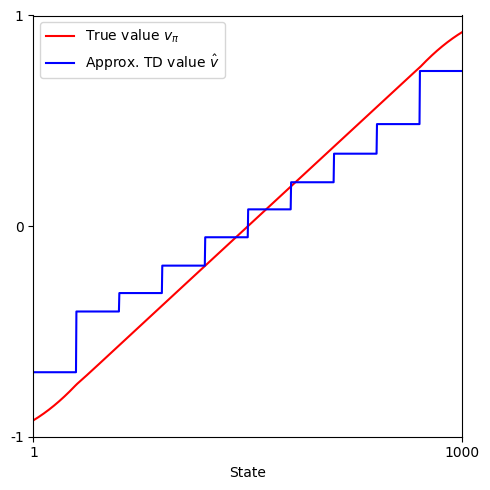

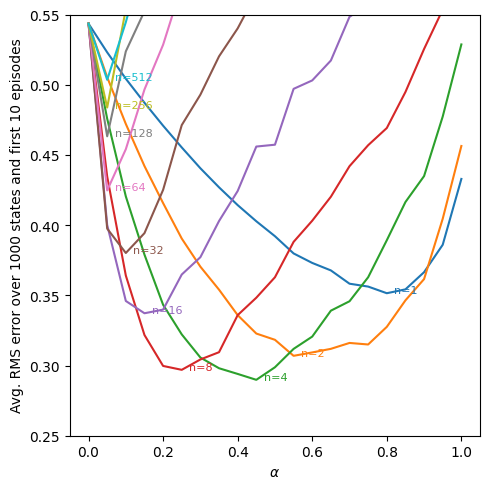

In [325]:
def main():
    """
    Main function:
    1. Produce left figure (final value function from semi-gradient TD).
    2. Produce right figure (performance of n-step semi-gradient TD).
    """
    # Left figure
    plot_first_figure()
    plt.show()

    # Right figure
    errors = collect_data_for_second_plot()
    plot_second_figure(errors)
    plt.show()

if __name__ == '__main__':
    main()
